# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

def Log(x): 
    return(np.log(1 - x + 0.1))# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator, CloudyGenerator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
#D = [Load_FLX_dict('DictPrepross2.hdf5')]
#normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size*500, custom_b_p_e=100)
#D[0].fitonGen(normal_generator, axis=1)
#del(normal_generator)

In [3]:
#X = D[0].to_array_save()
#X.to_hdf('DictPrepross2.hdf5', key='s')

In [4]:
#X = D[0].to_array_save()
#D[0].to_hdf('DictPrepross2.hdf5', key='s')

In [5]:
##### Kernels
D=[Load_FLX_dict('DictPrepross2.hdf5')]
def Bin(x): 
    x[np.where(x!=0)] = 1
#    x[np.where(x==0)] = 0
    return(x)

Klist0 = []
Klist =[]# FKernel(identity, ['ql']), FKernel(identity, ['qi']) ]

D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

fit_genator =FLX_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

In [6]:
# V
V = [VarSuppression(['ts', 'frocean', 'frlake','frland','frlandice', 'frseaice'])]

##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = FLX_Generator(folder='Data3', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [7]:
#train_generator._div = train_generator._div - 1
#train_generator.idx_file=np.arange(train_generator._div)
#validation_generator._div = 1
#validation_generator.idx_file=np.array([train_generator._div])

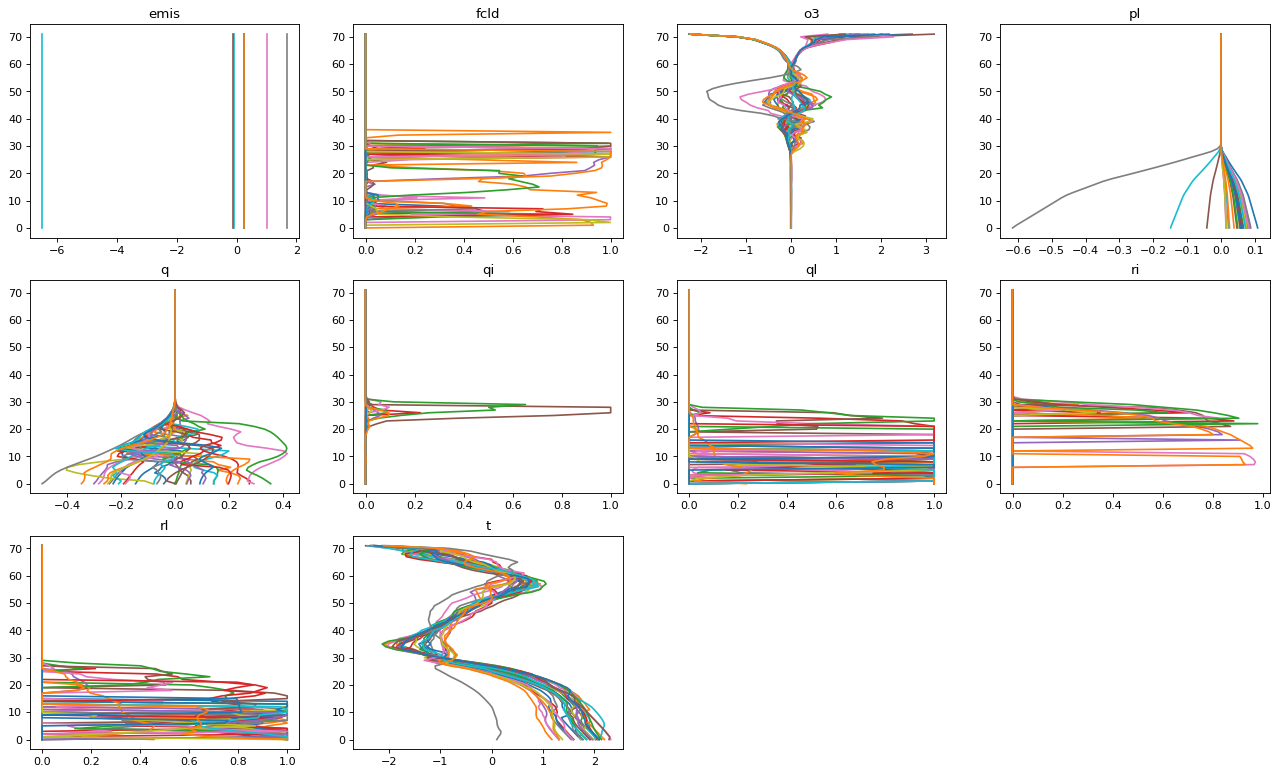

In [8]:
x,y = train_generator[0]
Plot_Batch(x,header_x)

### Model construct

import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72

list_of_filters_ae =  [[5, 18], [30, 30, 50, 50, 100, 100], [40, 20, 10], [50, 50, 100, 100, 100, 100], [10]]
list_of_kernel_ae =  [[10, 5], [2, 5, 2, 5, 2, 4], [], [3, 4, 3, 5, 3, 6], [5]]
list_of_activation_ae =  [['relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu']]

params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, 2))
M_Up2 = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))

M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activation_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=2)
M_f = Divide_Recombine(o_channel, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

M.summary()
M.load_weights('SavedModels/Best_AE')

In [10]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72
reg=10e-5
list_of_filters_ae =  [[32, 64, 64, 128], 
                       [30, 30, 50, 50, 128, 128], 
                       [40, 10], 
                       [64, 64, 128, 128, 128, 128], 
                       [256, 32, 2]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 3]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['tanh', 'tanh', 'tanh'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

params_ae = [0.01]
M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=1e-7)
#M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)
#M_f.trainable = False

Sub_f = lambda x: x[:,:,0] - x[:,:,1]
Sub = keras.layers.Lambda(Sub_f)
#model = keras.Model(Input0, Sub)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
#M.add(M_f); M.layers[-1].name = 'Div_Rec'
M.add(Sub); M.layers[-1].name = 'Substract'
#M.add(Flatten())
M.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:27: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `Av

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 10)            0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1336146   
_________________________________________________________________
Substract (Lambda)           (None, 72)                0         
Total params: 1,336,146
Trainable params: 1,336,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

#def Up_Down_loss(y_true, y_pred):
#    E = flxd_loss(y_true, y_pred)
#    E += flxu_loss(y_true, y_pred)
#    return E

def Up_Down_loss(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred))

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'UNet_Double'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
M.compile(loss = Up_Down_loss, optimizer=Adam, metrics=[Up_Down_loss] )
M.summary()

In [14]:
#train_generator.max_b=500
#M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False, epochs=1)

In [15]:
#train_generator.max_b=500
#M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False, epochs=1)

In [16]:
#train_generator.max_b=0
#M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH, ES], shuffle=False, epochs=10)

In [ ]:
# IMPORTANT MODEL LOG SAVER
#archi = 'Udouble_AE_copier'
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activations_unet = ', list_of_activations_ae)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

In [ ]:
flxu_loss_h = LH.losses['loss'][1:-1].copy()
#flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxu_loss_h)
#ax.plot(flxd_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['loss']);

In [39]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, _ in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder='Data2/', 
                                       batch_size=train_generator.batch_per_file*train_generator.batch_size,
                                       train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
#V = Plot_Earth(M, train_generator, 5)
#V=np.array(V)
#np.save('pred_best_Unet',V)

100%|██████████| 25/25 [10:24<00:00, 26.06s/it]


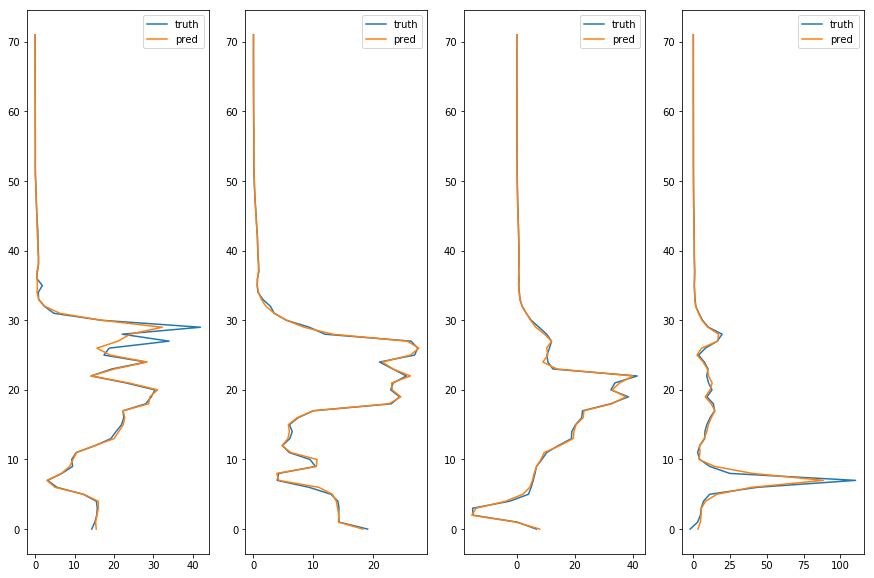

In [11]:
from utils import F_and_plots, Plot_diff
M.load_weights('BestModels/Best_Unet_[double_output]_4epochs')

i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

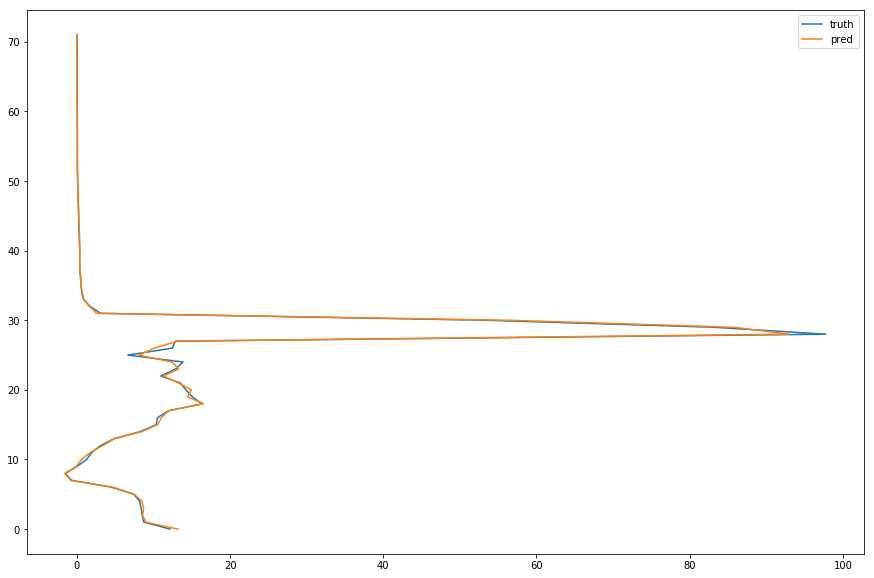

In [54]:
Plot_diff( F_and_plots(shape=(1,1)), y,y0, header_y=['flx'], J=[4])

In [19]:
MSE_e=K.get_value(Up_Down_loss(y,y0))
MSE_e = np.mean(MSE_e, axis=1)
np.argmin(MSE_e)

16

In [22]:
validation_generator.batch_size = int(validation_generator.batch_per_file*validation_generator.batch_size)

In [23]:
X,Y = validation_generator[0]
Y0 = M.predict(X)
MSE_e = K.get_value(Up_Down_loss(Y0,Y))
del(X,Y)
y_argmin = np.argmin(MSE_e)
validation_generator.batch_size = 32
x,y = validation_generator[y_argmin//32]
y0 = M.predict(x)
m = K.get_value(Up_Down_loss(y,y0))
xmin = x[[np.argmin(m)]]

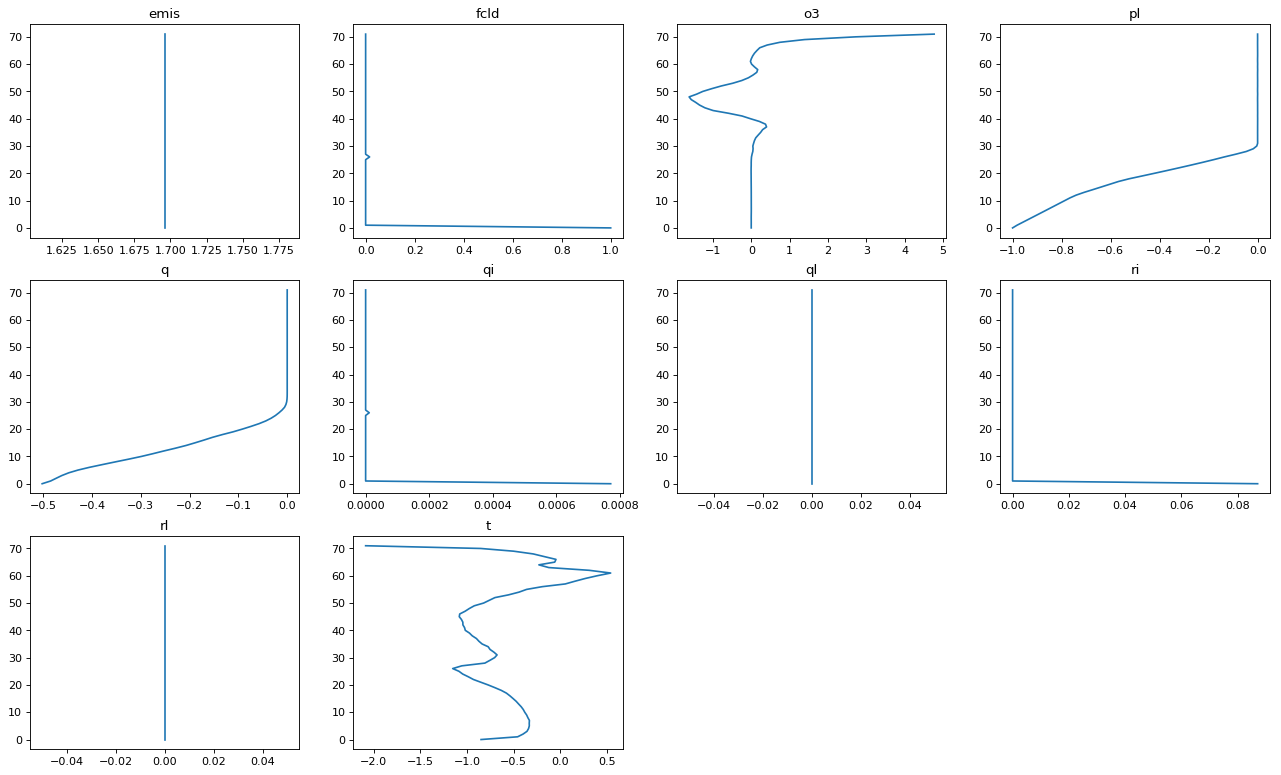

In [24]:
Plot_Batch(xmin, header_x)

In [25]:
def Jacobian(M,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = np.zeros((lev*n_var, lev))
    # could be more optimize [l steps instead of l*n_var]
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            x0[0,l , v] += 1/dt
            P0[v*lev+l] = M.predict(x0)
    P1 = M.predict(x)
#    print(P0[0] - P1[0])
    return (P1-P0).T

J = Jacobian(M, xmin, 10000)

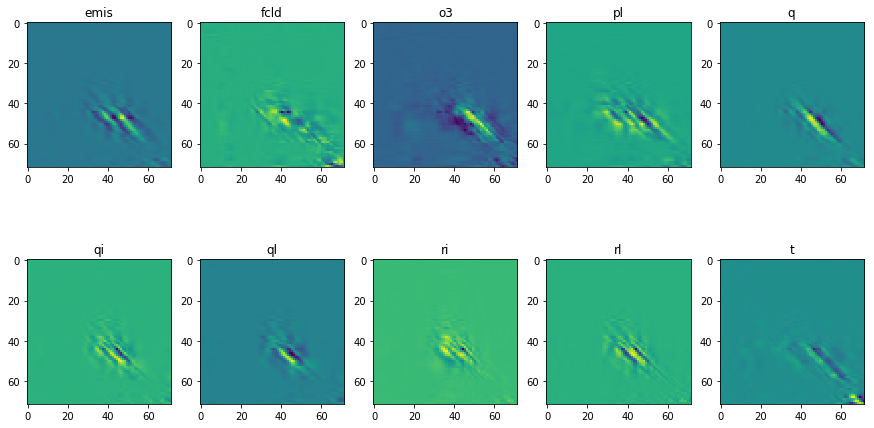

In [26]:
F=F_and_plots(figsize=(15,8), shape=(2,5))



Sep_Var_show(F,J, header_x)
J2 = Divide(J, header_x)

In [ ]:
len(tr)

In [27]:
for i in J2:
    print(np.max(i), np.min(i))

0.0003237724304199219 -0.00021457672119140625
0.000232696533203125 -0.0003876686096191406
0.00014138221740722656 -6.794929504394531e-05
0.00017452239990234375 -0.00024962425231933594
0.0031156539916992188 -0.002803802490234375
0.0018143653869628906 -0.003237485885620117
0.0139923095703125 -0.011138439178466797
0.00028443336486816406 -0.0006031990051269531
0.0007419586181640625 -0.0012843608856201172
0.00020444393157958984 -0.0002016127109527588


In [29]:
import tqdm
G=[]
for i in tqdm.tqdm(range(72)):
    gradients = K.gradients(M.get_output_at(0)[:,i],M.input)
    gradients_f = K.function( [M.input] , [gradients[0]] )
    G.append(gradients_f([x[[0]]])[0])

G=np.array(G)
G = G[:,0,:,:]
G0 = G.swapaxes(1,2)
G0 = G0.reshape(72,720)

100%|██████████| 72/72 [02:20<00:00,  3.06s/it]


In [31]:
np.save('Tf_grad_best_model', G0)

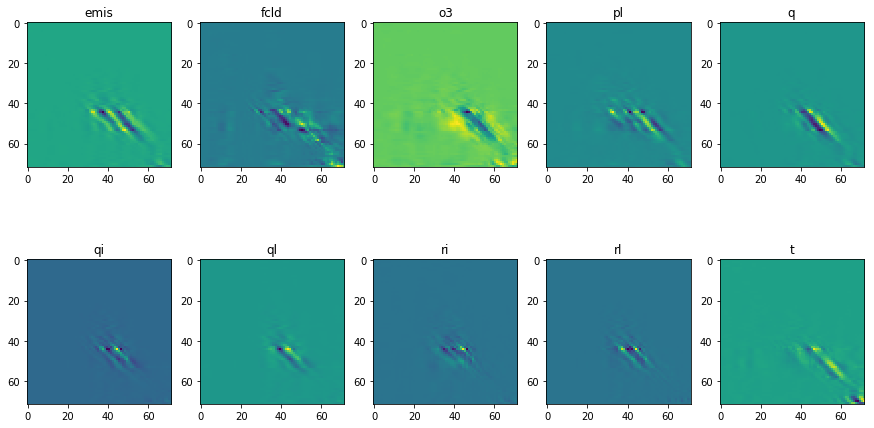

In [32]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,G0, header_x)

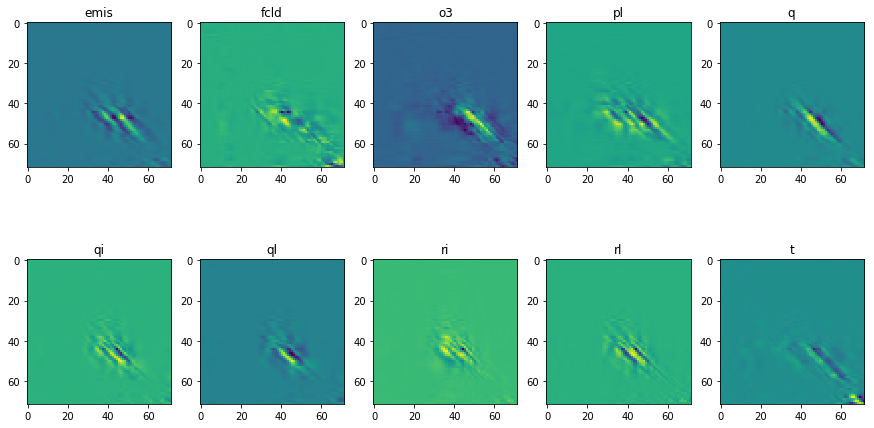

In [33]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,J, header_x)

In [ ]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,10000*J+G0, header_x)

In [52]:
for j,i in enumerate(G2-J2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4753172397613525 -5.038313627243042
fcld 4.450602293014526 -3.2322890758514404
o3 0.9157004952430725 -2.905653238296509
pl 4.1315600872039795 -3.7754268646240234
q 49.70502281188965 -54.84940028190613
qi 69.43060564994812 -36.00625824928284
ql 247.81062531471252 -280.3574583530426
ri 9.647634029388428 -5.988334655761719
rl 25.624382734298706 -15.990925073623657
t 3.0675272941589355 -4.052147626876831


In [49]:
for j,i in enumerate(G2):
    print(header_x[j], np.max(i), np.min(i))

emis 3.4751897 -5.038152
fcld 4.450342 -3.2321835
o3 0.91567427 -2.9055223
pl 4.131408 -3.7752972
q 49.702225 -54.847145
qi 69.42737 -36.005356
ql 247.80237 -280.35013
ri 9.647031 -5.988172
rl 25.623098 -15.990633
t 3.0673404 -4.051973


In [50]:
for j,i in enumerate(J2*10000):
    print(header_x[j], np.max(i), np.min(i))

emis 3.2377243041992188 -2.1457672119140625
fcld 2.32696533203125 -3.8766860961914062
o3 1.4138221740722656 -0.6794929504394531
pl 1.7452239990234375 -2.4962425231933594
q 31.156539916992188 -28.03802490234375
qi 18.143653869628906 -32.37485885620117
ql 139.923095703125 -111.38439178466797
ri 2.8443336486816406 -6.031990051269531
rl 7.419586181640625 -12.843608856201172
t 2.0444393157958984 -2.016127109527588


In [47]:
from generator import Full_Diff_Generator
test_gen = Full_Diff_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
test_gen.list_files = [24]

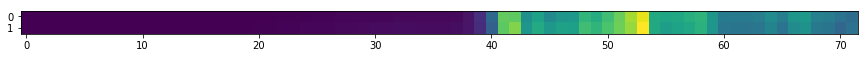

In [50]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = test_gen[100]

y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
#Last_layer = K.function( [i1],[o4])
Last_layer = K.function( [i1],[o5])


#img = Dense_layer(First_model([x]))[0]
img = Last_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

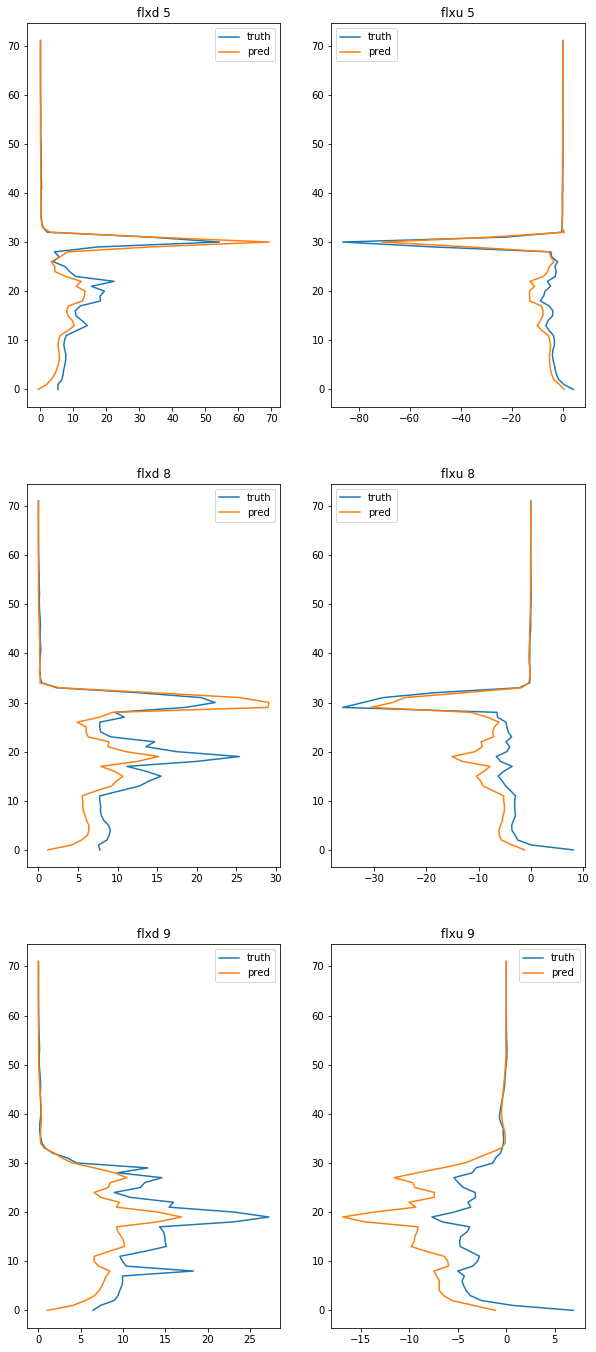

In [76]:
def Plot_diff(F, y,y0, header_y, lev=72, J = [0], titles=False):
    for l in range(len(header_y)):
        for ind,i in enumerate(J):
            F[ind*len(header_y) + l].plot(np.flip(y[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].plot(np.flip(y0[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].legend(["truth", "pred"])
            if titles !=False:
                F[ind*len(header_y) + l].set_title(header_y[l] + ' '+ str(titles[ind]))
                

J=[5,8,9]
F = F_and_plots(figsize=(5*2,len(J)*8), shape=(len(J), 2))
Plot_diff(F, y, img, ['flxd', 'flxu'], J=J, titles=J)

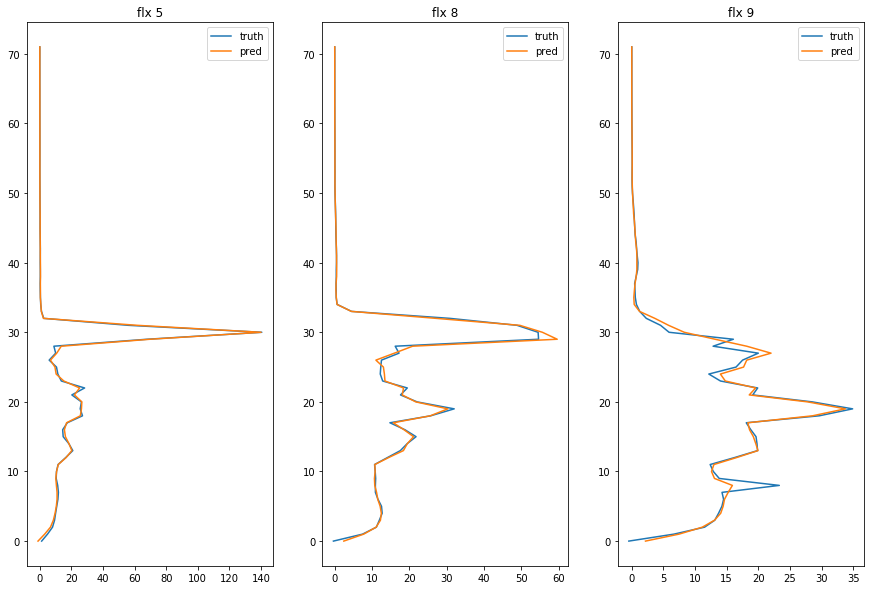

In [73]:
F = F_and_plots(figsize=(15,10), shape=(1,len(J)))
Plot_diff(F, y[:,:,[0]]-y[:,:,[1]], y0.reshape(32,72,1), ['flx'], J=J, titles=J)

In [70]:
y0.shape

(32, 72)